In [3]:
import os
os.chdir('../')

## Sanity check on cached causal conv 1d

In [4]:
import torch
import matplotlib.pyplot as plt

from cached_conv import CausalConv1dCached

Max absolute error (stream vs offline): 0
Stepwise equals offline: True


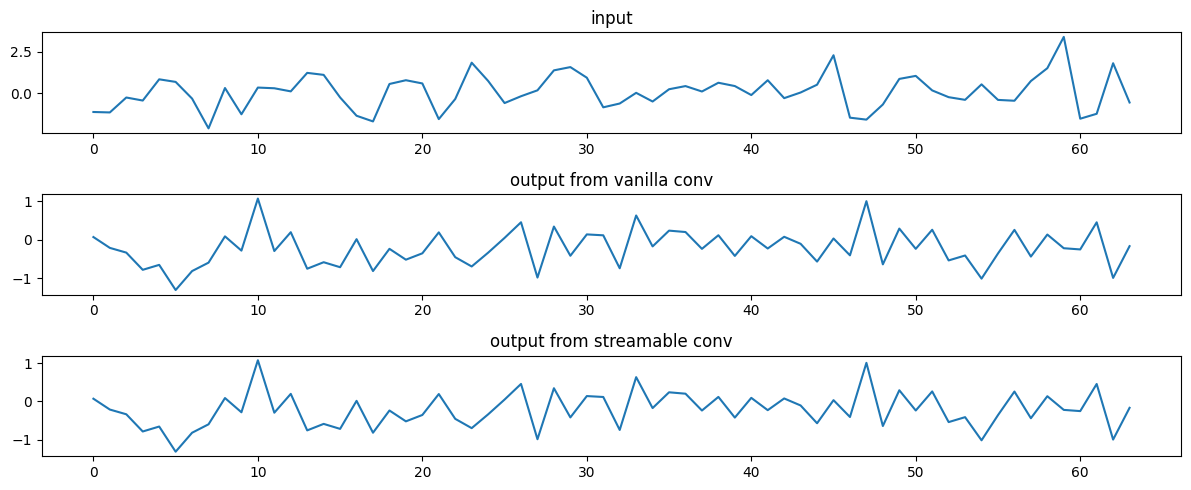

In [12]:
torch.manual_seed(0)

B, C_in, C_out = 2, 3, 4
K, D = 5, 2        # kernel_size=5, dilation=2  -> cache_len = (5-1)*2 = 8
T_total = 64

x = torch.randn(B, C_in, T_total)

layer = CausalConv1dCached(C_in, C_out, kernel_size=K, dilation=D, bias=True)
layer.eval()  # typical for streaming inference

# Offline "ground truth" (one shot, zero-left-padded)
y_offline = layer.forward_full(x)

# Streaming over uneven chunks
chunk_sizes = [7, 5, 9, 1, 16, 8, 18]  # sums to 64
assert sum(chunk_sizes) == T_total

layer.clear_cache()  # begin a fresh stream
outs = []
start = 0
for n in chunk_sizes:
    chunk = x[:, :, start:start+n]            # (B, C_in, n)
    y_chunk = layer(chunk, use_cache=True)    # (B, C_out, n)
    outs.append(y_chunk)
    start += n

y_stream = torch.cat(outs, dim=-1)

# Check equivalence
max_abs_err = (y_offline - y_stream).abs().max().item()
print(f"Max absolute error (stream vs offline): {max_abs_err:.6g}")
assert torch.allclose(y_offline, y_stream, atol=1e-6), "Streaming does not match offline!"

# Optional: single-step usage (T=1 per call)
layer.clear_cache()
outs_step = []
for t in range(T_total):
    y_t = layer(x[:, :, t:t+1], use_cache=True)  # (B, C_out, 1)
    outs_step.append(y_t)
y_step = torch.cat(outs_step, dim=-1)
print(f"Stepwise equals offline: {torch.allclose(y_step, y_offline, atol=1e-6)}")

# plot
b = 0
c = 0
plt.figure(figsize=(12, 5))

plt.subplot(3, 1, 1)
plt.title('input')
plt.plot(x[b, c, :])

plt.subplot(3, 1, 2)
plt.title('output from vanilla conv')
plt.plot(y_offline.detach()[b, c, :])

plt.subplot(3, 1, 3)
plt.title('output from streamable conv')
plt.plot(y_stream.detach()[b, c, :])

plt.tight_layout()
plt.show()

### Notes

- The internal cache is per-(batch, channel) and is reallocated automatically if batch size, dtype, or device changes.

- `detach_cache_grad=True` (default) keeps streaming clean for inference and avoids cross-chunk graph growth. If you’re doing chunked training and need gradients to flow across chunk boundaries, pass `detach_cache_grad=False`.

- If you need to checkpoint/resume a stream, use `get_state()` / `set_state()` to export/import the cache.

- For typical streaming setups, keep `stride=1`. If you need strided streaming, you’ll usually pair this with decimation logic in your pipeline (not shown here).

## Sanity check on cached causal conv 2d

Max absolute error (stream vs offline): 0
Per-column equals offline: True


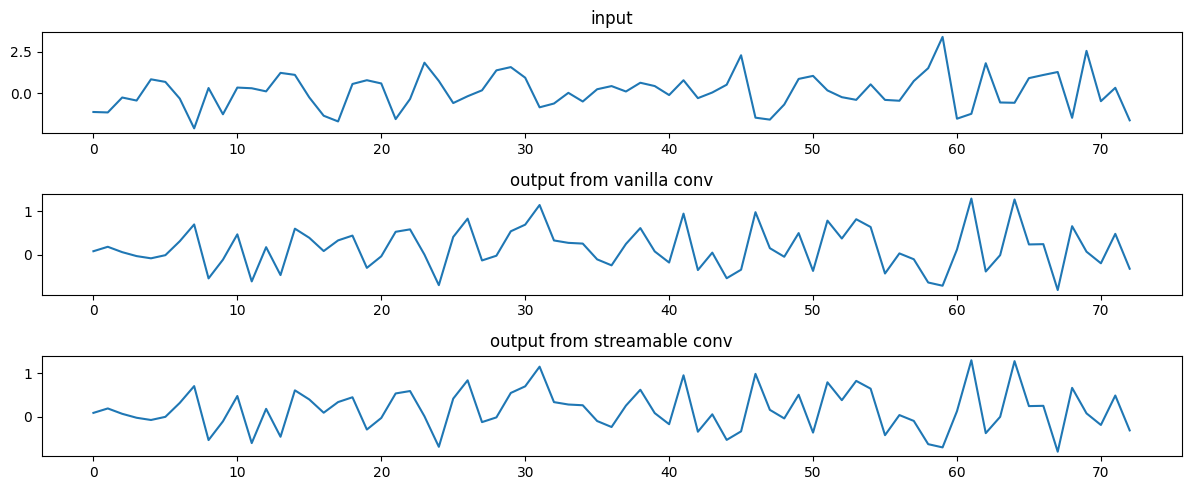

In [11]:
from cached_conv import CausalConv2dCached

torch.manual_seed(0)

B, C_in, C_out = 2, 3, 4
H, W_total = 6, 73

kh, kw = 3, 5
dh, dw = 1, 2          # dilation along width = 2  -> cache_len = (5-1)*2 = 8
stride_h = 2           # vanilla vertical stride
padding_h = 1          # keep height roughly "same" for kh=3, stride_h=2

x = torch.randn(B, C_in, H, W_total)

layer = CausalConv2dCached(
    C_in, C_out,
    kernel_size=(kh, kw),
    dilation=(dh, dw),
    stride_h=stride_h,
    padding_h=padding_h,
    bias=True,
)
layer.eval()

# Offline ground truth (width-causal, height-vanilla)
y_offline = layer.forward_full(x)

# Stream over arbitrary width chunks (height is full each time)
chunk_sizes = [7, 4, 13, 1, 9, 16, 8, 15]  # sums to 73
assert sum(chunk_sizes) == W_total

layer.clear_cache()
outs = []
start = 0
for n in chunk_sizes:
    chunk = x[:, :, :, start:start+n]         # (B, C_in, H, n)
    y_chunk = layer(chunk, use_cache=True)    # (B, C_out, H_out, n)
    outs.append(y_chunk)
    start += n

y_stream = torch.cat(outs, dim=-1)

max_abs_err = (y_offline - y_stream).abs().max().item()
print(f"Max absolute error (stream vs offline): {max_abs_err:.6g}")
assert torch.allclose(y_offline, y_stream, atol=1e-6), "Streaming != offline!"

# Optional: strict single-column streaming
layer.clear_cache()
outs_cols = []
for t in range(W_total):
    y_t = layer(x[:, :, :, t:t+1], use_cache=True)   # (B, C_out, H_out, 1)
    outs_cols.append(y_t)
y_cols = torch.cat(outs_cols, dim=-1)
print(f"Per-column equals offline: {torch.allclose(y_cols, y_offline, atol=1e-6)}")

# plot
b = 0
c = 0
h = 0
plt.figure(figsize=(12, 5))

plt.subplot(3, 1, 1)
plt.title('input')
plt.plot(x[b, c, h, :])

plt.subplot(3, 1, 2)
plt.title('output from vanilla conv')
plt.plot(y_offline.detach()[b, c, h, :])

plt.subplot(3, 1, 3)
plt.title('output from streamable conv')
plt.plot(y_stream.detach()[b, c, h, :])

plt.tight_layout()
plt.show()